## Imports/Setup

In [1]:
%run ../00_functions/00_custom_functions.ipynb
standard_setup(extra_packages=True, verbose=False)
data_ingestion_prep(start_yearmonth='1979-01', end_yearmonth='2022-12', verbose=False)

env: ESMFMKFILE=/home/ds4114/.conda/envs/leap_test202308-3/lib/esmf.mk
Files will be outputed as: .nc
ECMWF CDS API key already installed


In [2]:
from xgboost import XGBRegressor
import cmocean as cm    
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
#optionally turn off some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Set Parameters

In [3]:
full_dataset_file = global_vars['reconstruction_folder']  + 'HPD_LEAP_fco2-full-dataset-preML_198201-202304.nc' #name of file from previous script
print(full_dataset_file)

/data/artemis/workspace/ds4114/reconstructions/HPD_LEAP_fco2-full-dataset-preML_198201-202304.nc


In [4]:
#The following two variables will cut the data to use for training (and prediction)
ml_start_yearmonth = '1982-01'  
ml_end_yearmonth = '2022-12'   

# Parameters from prior exploration for consistency:
random_seeds = np.array([97]) #historically used for train/test split
print(f'Random Seeds {random_seeds}')
best_params = {        'random_state':42,
                      'max_depth': 9, 
                      'min_child_weight': 1, 
                      'gamma': 0,
                      'subsample': 0.85,
                      'colsample_bytree': 0.95,
                      'reg_alpha': 0.09,
                      'reg_lambda': 1,
                      'n_estimators': 1500,
                      'learning_rate': 0.05,
                     }
jobs = -1         #Number of cores you have access to for model training; -1 for all available ones

#This variable is a list of features used for machine learning
#Note that the net_mask variable will be used regardless to only train on ocean areas (not land or coast)
feature_sel = ['sst','sst_anomaly','sss','sss_anomaly','chl_log','chl_log_anomaly','mld_log','xco2_trend','A','B','C','T0','T1']
#target_sel = ['error']  

#This variable is a list of GOBM models in which to calculate the error correction. It should match the variable names in the dataframe.
gobm_list = ['CNRM-ESM2-1', 'FESOM2-REcoM', 'IPSL', 'MOM6-Princeton', 
               'MRI-ESM2-2','NorESM-OC1.2', 'CESM-ETHZ', 'ACCESS']

Random Seeds [97]


In [5]:
#for debugging
#ml_start_yearmonth, ml_end_yearmonth = '2022-01' , '2022-12' 

## Machine Learning

In [5]:
#df03 = xr.open_dataset('/data/artemis/workspace/afay/LDEO_HPD/models/XGB/GCB_2023/HPD_2023_df_preML_v2_198201-202304.nc')
df03 = xr.open_dataset(full_dataset_file)
assert df03.get(gobm_list) is not None #if error, check the GOBM list above matches the dataframe variable names

df03 = df03.sel(time=slice(str(ml_start_yearmonth),str(ml_end_yearmonth))) #filter time frame
xr_full_mod_output =  df03.get(['fco2','net_mask'] + gobm_list)   #base xr that is our output. error correction values will be added to this

In [7]:
%%time 

#Main loop to learn error correction
for mod in gobm_list:
    print(f'----------Starting {mod} on '+datetime.datetime.now().strftime('%Y-%m-%d %H:%M')+'...----------')
    
    #filter data for relevant rows and columns
    xr_for_ml = df03.get(feature_sel + ['fco2'] + [mod] + ['net_mask'])
    xr_for_ml = xr_for_ml.assign( error = xr_for_ml.fco2 - xr_for_ml[mod])
    df = xr_for_ml.to_dataframe() #for ease of working with pandas
    df_for_ml = df[(~df.isna().any(axis=1))]  #only keep points that are not null
    print(f'Number of points in time/space available to train: {df_for_ml.shape[0]}')
    df_for_recon = df.loc[:,feature_sel + ['net_mask']]
    df_for_recon = df_for_recon[(~df_for_recon.isna().any(axis=1))]  
    print(f'Number of points in time/space to reconstruct: {df_for_recon.shape[0]}')
    
    #df_for_ml = df_for_ml.drop('net_mask', axis=1) #remove net_mask variable since not used in training? Prior code has it in; since all 1 value no impact

    #split into train and test sets 
        #original code created train, validation, and test sets but because development already completed and no more cross validation/hyperparameter tuning, we can just use train/test
        #note that according to historic work, we do not divide based on time meaning all rows are scrambled and used IID to train
    df_train, df_test = train_test_split(df_for_ml, test_size=0.2, random_state=random_seeds[0])
    X_train = df_train.loc[:,feature_sel]
    y_train = df_train.loc[:,'error']
    X_test = df_test.loc[:,feature_sel]
    y_test = df_test.loc[:,'error']
    
    print('-------Training...')
    model = XGBRegressor(**best_params, n_jobs=jobs)
    model.fit(X_train, y_train) 
    print('-------Evaluating Performance...-------')
    y_pred_test = model.predict(X_test)
    test_performance = evaluate_test(y_test.to_numpy().ravel(), y_pred_test)
    print_dict_as_table(test_performance) #print(test_performance)
    
    #do we save anything from model? Perhaps just the reconstruction
    print('-------Reconstructing...')
    error_correction = model.predict(df_for_recon.loc[:,feature_sel])
    df_for_recon[mod+'_error_correction'] = error_correction #add predictions back to dataframe
    xr_recon = df_for_recon[mod+'_error_correction'].to_xarray() #convert back to xr to merge
    xr_full_mod_output = xr_full_mod_output.merge(xr_recon, compat='identical')
    
    print(f'GOBM Model Complete \n')

----------Starting CNRM-ESM2-1 on 2023-10-10 20:35...----------
Number of points in time/space available to train: 288270
Number of points in time/space to reconstruct: 16589101
-------Training...
-------Evaluating Performance...-------
mse      : 171.937      bias     : -0.008       stdev    : 26.847       iqr_ref  : 32.563       
mae      : 8.622        r2       : 0.820        amp_ratio: 0.712                                
medae    : 5.844        corr     : 0.906        stdev_ref: 30.903                               
max_error: 273.060      cent_rmse: 13.112       range_ref: 473.468                              

-------Reconstructing...
GOBM Model Complete 

----------Starting FESOM2-REcoM on 2023-10-10 20:39...----------
Number of points in time/space available to train: 284004
Number of points in time/space to reconstruct: 16589101
-------Training...
-------Evaluating Performance...-------
mse      : 166.891      bias     : 0.040        stdev    : 31.998       iqr_ref  : 42.180

In [8]:
xr_full_mod_output

<xarray.Dataset>
Dimensions:                          (time: 492, xlon: 360, ylat: 180)
Coordinates:
  * time                             (time) datetime64[ns] 1982-01-15 ... 202...
  * xlon                             (xlon) float64 -179.5 -178.5 ... 179.5
  * ylat                             (ylat) float64 -89.5 -88.5 ... 88.5 89.5
Data variables: (12/18)
    fco2                             (time, ylat, xlon) float32 ...
    net_mask                         (ylat, xlon) float32 ...
    CNRM-ESM2-1                      (time, ylat, xlon) float64 ...
    FESOM2-REcoM                     (time, ylat, xlon) float64 ...
    IPSL                             (time, ylat, xlon) float64 ...
    MOM6-Princeton                   (time, ylat, xlon) float64 ...
    ...                               ...
    IPSL_error_correction            (time, ylat, xlon) float32 nan nan ... nan
    MOM6-Princeton_error_correction  (time, ylat, xlon) float32 nan nan ... nan
    MRI-ESM2-2_error_correction      (time, ylat, xlon) float32 nan nan ... nan
    NorESM-OC1.2_error_correction    (time, ylat, xlon) float32 nan nan ... nan
    CESM-ETHZ_error_correction       (time, ylat, xlon) float32 nan nan ... nan
    ACCESS_error_correction          (time, ylat, xlon) float32 nan nan ... nan
Attributes:
    description:                     fCO2-Residual dataset for machine learning
    formula_for_co2_residual:        uses 0.0413 factor from Wanninkhof et al...
    training_features_for_co2_mean:  ['sst', 'sst_anomaly', 'sss', 'sss_anoma...
    hyperparameters_for_co2_mean:    {'max_depth': 9, 'n_estimators': 1000}
    created:                         2023-08-11 15:42:06.375778

In [9]:
#add attributes - tbd
#output to file
output_xarray_with_date(xr_full_mod_output, global_vars['reconstruction_folder']+'', 'HPD_LEAP_fco2-error-reconstructed-8-GOBMs', filetype=output_file_type)

Saved HPD_LEAP_fco2-error-reconstructed-8-GOBMs_198201-202212.nc to /data/artemis/workspace/ds4114/reconstructions/


## View Results

In [6]:
xr_full_mod_output = xr.open_dataset('/data/artemis/workspace/ds4114/reconstructions/HPD_LEAP_fco2-error-reconstructed-8-GOBMs_198201-202212.nc')

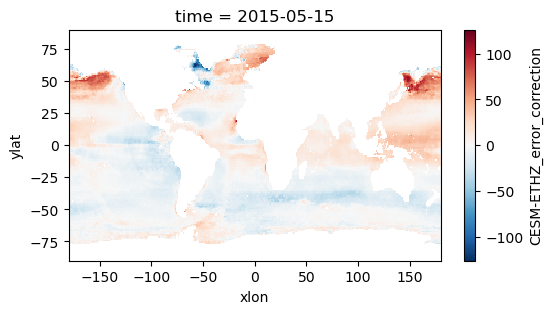

In [7]:
fig = plt.figure(figsize=(figsizew,figsizeh))
xr_full_mod_output['CESM-ETHZ_error_correction'][400,:,:].plot();

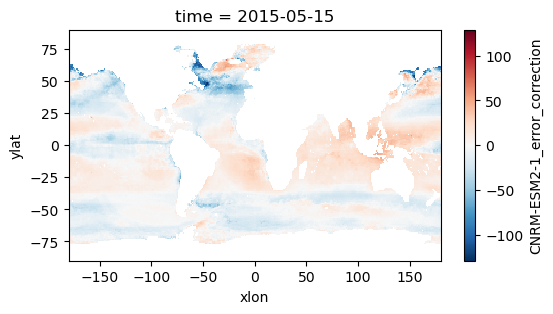

In [8]:
fig = plt.figure(figsize=(figsizew,figsizeh))
xr_full_mod_output['CNRM-ESM2-1_error_correction'][400,:,:].plot();

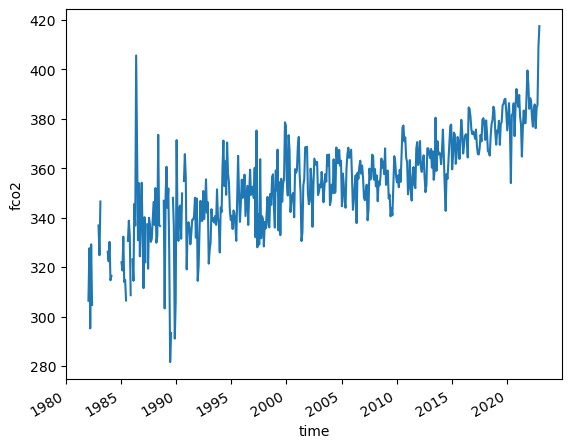

In [13]:
#xr_full_mod_output['CNRM-ESM2-1_error_correction'].mean(['ylat','xlon']).plot()
xr_full_mod_output['fco2'].mean(['ylat','xlon']).plot()